In [1]:
import os
import re
import ast
import importlib
import uuid
import json
import ast

from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict
from enum import Enum

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

from langchain_core.prompts import ChatPromptTemplate

import pandas as pd

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up LLMs, state and interrupt messages

In [5]:
# helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
# account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
# music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o")

In [6]:
class NodeType(str, Enum):
    ROUTER = "router"
    QUERY = "query"
    UPDATE = "update"
    HUMAN_APPROVAL = "human_approval"
    RESPONSE = "response"

class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    next_node: NodeType
    approved: Optional[bool]
    current_mode: Literal["router", "account", "music"]
    subsequent_account_query: Optional[str]

In [7]:
customer_id_interrupt_message = "Please provide your customer ID to help me assist you better."
action_confirmation_interrupt_message = "This action will update the database. Please confirm that you want to proceed (yes/no)"

# Helper Functions

In [8]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Music Recommendation Agent

## Create Artist and Song retrievers to allow inexact matching of for artists and tracks/songs names

In [9]:
artists = db._execute("SELECT * FROM artists")
songs = db._execute("SELECT * FROM tracks")
artist_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in artists],
    OpenAIEmbeddings(),
    metadatas=artists
).as_retriever()

song_retriever = SKLearnVectorStore.from_texts(
    [a['Name'] for a in songs],
    OpenAIEmbeddings(),
    metadatas=songs
).as_retriever()

## Define Tools to get recommendations

### Tools not specific to a customer

In [10]:
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist (or similar artists)."""
    docs = artist_retriever.invoke(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT Title, Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    docs = artist_retriever.invoke(artist)
    artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
    return db.run(
        f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});",
        include_columns=True)


@tool
def search_songs(song_title: str):
    """Search for songs by title."""
    docs = song_retriever.invoke(song_title)
    return [{"Title": doc.page_content, "TrackId": doc.metadata["TrackId"]} for doc in docs[:5]]


@tool
def get_similar_music(genre: str, artist: str = ""):
    """Get music recommendations based on genre and optionally artist."""
    # Find genre ID
    genre_query = f"""
    SELECT GenreId FROM genres 
    WHERE Name LIKE '%{genre}%' 
    LIMIT 1
    """
    genre_result = db.run(genre_query)
    if not genre_result:
        return f"No genre found matching '{genre}'"

    # Genre result comes as a string like "[(1,)]" - parse it
    genre_id = int(genre_result.strip("[]() \t\n,").split(",")[0])

    # Get tracks in that genre, optionally filtering by artist
    artist_filter = ""
    if artist:
        docs = artist_retriever.invoke(artist)
        if docs:
            artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
            artist_filter = f"AND albums.ArtistId IN ({artist_ids})"
    
    query = f"""
    SELECT tracks.Name as TrackName, artists.Name as ArtistName, albums.Title as AlbumTitle
    FROM tracks
    JOIN albums ON tracks.AlbumId = albums.AlbumId
    JOIN artists ON albums.ArtistId = artists.ArtistId
    WHERE tracks.GenreId = {genre_id} {artist_filter}
    ORDER BY RANDOM()
    LIMIT 5
    """
    
    result = db.run(query, include_columns=True)
    
    if not result:
        return f"No songs found for genre '{genre}'" + (f" and artist '{artist}'" if artist else "")
    
    try:
        # Try using ast.literal_eval which is safer than eval
        tracks = ast.literal_eval(result)
    except:
        try:
            # If ast fails, try json.loads (might need some string cleaning)
            # Replace single quotes with double quotes for valid JSON
            cleaned_result = result.replace("'", '"')
            tracks = json.loads(cleaned_result)
        except:
            # If both methods fail, return an error message
            return "Error parsing database results. Please check the result format."
    
    formatted_result = "Here are some similar tracks:\n\n"
    for track in tracks:
        formatted_result += f"- {track['TrackName']} by {track['ArtistName']} (Album: {track['AlbumTitle']})\n"
    
    return formatted_result


@tool
def get_track_price_by_id(track_id: int):
    """
    Look up the price of a track by its ID directly from the tracks table.
    
    Args:
        track_id: The track ID to look up
    
    Returns:
        The price and name of the track
    """
    # Query for the price directly from the tracks table
    query = f"""
    SELECT 
        t.UnitPrice as Price, 
        t.Name as TrackName,
        ar.Name as ArtistName
    FROM tracks t
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    WHERE t.TrackId = {track_id}
    """
    
    result = db.run(query, include_columns=True)
    if not result:
        return f"No track found with ID {track_id}"
    return result

### Tools specific to a customer

In [11]:
@tool
def get_customer_top_genres(customer_id: int, limit: int = 5):
    """Identify a customer's favorite genres based on purchase history."""
    return db.run(f"""
        SELECT g.Name as Genre, COUNT(ii.InvoiceLineId) as PurchaseCount
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_customer_top_artists(customer_id: int, limit: int = 5):
    """Identify a customer's favorite artists based on purchase history."""
    return db.run(f"""
        SELECT ar.Name as Artist, COUNT(ii.InvoiceLineId) as PurchaseCount,
               SUM(ii.UnitPrice) as TotalSpent
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY PurchaseCount DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def check_track_purchase_history(customer_id: int, track_name: str):
    """Check if and when a customer purchased a specific track."""
    # First, find tracks that match the provided name
    docs = song_retriever.invoke(track_name)
    if not docs:
        return f"No tracks found matching '{track_name}'"
    
    track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
    
    return db.run(f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id} AND t.TrackId IN ({track_ids})
        ORDER BY i.InvoiceDate DESC;
    """, include_columns=True)

@tool
def get_recommended_tracks_from_purchase_history(customer_id: int, limit: int = 5):
    """Get personalized track recommendations based on purchase history."""
    # First, get the customer's top genres
    top_genres_query = """
        SELECT g.Name as Genre
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 2;
    """.format(customer_id=customer_id)
    
    genres_result = db.run(top_genres_query, include_columns=True)
    
    if not genres_result:
        return "No purchase history found to base recommendations on."
    
    # Get customer's purchased tracks to exclude them
    purchased_tracks_query = """
        SELECT t.TrackId
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        WHERE i.CustomerId = {customer_id};
    """.format(customer_id=customer_id)
    
    purchased_tracks_result = db.run(purchased_tracks_query)
    purchased_track_ids = []
    if purchased_tracks_result:
        # Extract track IDs from the SQL result
        for row in purchased_tracks_result.strip('[]').split('), ('):
            track_id = row.strip('()').split(',')[0]
            if track_id.isdigit():
                purchased_track_ids.append(int(track_id))
    
    # Get top artists (optional enhancement)
    top_artist_query = """
        SELECT ar.Name as Artist
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        GROUP BY ar.ArtistId
        ORDER BY COUNT(ii.InvoiceLineId) DESC
        LIMIT 1;
    """.format(customer_id=customer_id)
    
    artist_result = db.run(top_artist_query, include_columns=True)
    top_artist = artist_result[0]['Artist'] if artist_result else ""
    
    # Use the existing get_similar_music with the top genre
    recommendations = get_similar_music(genres_result[0]['Genre'], top_artist)
    
    # You could filter out already purchased tracks here if needed
    
    return recommendations

In [12]:
@tool
def summarize_music_taste(customer_id: int):
    """Provide a comprehensive analysis of the customer's music taste based on purchase history."""
    
    # Basic purchase statistics
    basic_stats_query = f"""
    SELECT 
        COUNT(DISTINCT ii.TrackId) AS TotalTracks,
        COUNT(DISTINCT i.InvoiceId) AS TotalPurchases,
        SUM(i.Total) AS TotalSpent,
        MIN(i.InvoiceDate) AS FirstPurchase,
        MAX(i.InvoiceDate) AS LastPurchase,
        COUNT(DISTINCT ar.ArtistId) AS UniqueArtists,
        COUNT(DISTINCT g.GenreId) AS UniqueGenres,
        COUNT(DISTINCT al.AlbumId) AS UniqueAlbums
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    """
    basic_stats = db.run(basic_stats_query, include_columns=True)
    
    if not basic_stats:
        return {"error": "No purchase history found for this customer."}
    
    # Genre preferences with percentages
    genre_query = f"""
    SELECT 
        g.Name AS Genre, 
        COUNT(ii.InvoiceLineId) AS TrackCount,
        ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
            SELECT COUNT(ii2.InvoiceLineId) 
            FROM invoice_items ii2
            JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
            WHERE i2.CustomerId = {customer_id}
        ), 2) AS Percentage
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    GROUP BY g.GenreId
    ORDER BY TrackCount DESC
    LIMIT 8
    """
    genres = db.run(genre_query, include_columns=True)
    
    # Top artists with purchase counts and percentage of collection
    artist_query = f"""
    SELECT 
        ar.Name AS Artist, 
        COUNT(ii.InvoiceLineId) AS TrackCount,
        ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
            SELECT COUNT(ii2.InvoiceLineId) 
            FROM invoice_items ii2
            JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
            WHERE i2.CustomerId = {customer_id}
        ), 2) AS Percentage,
        COUNT(DISTINCT al.AlbumId) AS AlbumCount
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    WHERE i.CustomerId = {customer_id}
    GROUP BY ar.ArtistId
    ORDER BY TrackCount DESC
    LIMIT 8
    """
    artists = db.run(artist_query, include_columns=True)
    
    # Favorite albums (albums with the most tracks purchased)
    album_query = f"""
    SELECT 
        al.Title AS Album, 
        ar.Name AS Artist,
        COUNT(ii.InvoiceLineId) AS TrackCount,
        COUNT(DISTINCT t.TrackId) AS UniqueTrackCount,
        (SELECT COUNT(t2.TrackId) FROM tracks t2 WHERE t2.AlbumId = al.AlbumId) AS TotalAlbumTracks,
        ROUND((COUNT(DISTINCT t.TrackId) * 100.0) / (SELECT COUNT(t2.TrackId) FROM tracks t2 WHERE t2.AlbumId = al.AlbumId), 2) AS AlbumCompletion
    FROM invoice_items ii
    JOIN invoices i ON ii.InvoiceId = i.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    WHERE i.CustomerId = {customer_id}
    GROUP BY al.AlbumId
    ORDER BY TrackCount DESC
    LIMIT 5
    """
    albums = db.run(album_query, include_columns=True)
    
    # Purchase trends over time (by quarter)
    trends_query = f"""
    SELECT 
        strftime('%Y-%m', i.InvoiceDate) AS Period,
        COUNT(ii.InvoiceLineId) AS Purchases,
        COUNT(DISTINCT g.GenreId) AS GenresDiversity,
        GROUP_CONCAT(DISTINCT g.Name) AS Genres
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    GROUP BY Period
    ORDER BY Period ASC
    """
    purchase_trends = db.run(trends_query, include_columns=True)
    
    # Compare to store average (for main genres)
    comparison_query = f"""
    WITH CustomerGenres AS (
        SELECT 
            g.GenreId, 
            g.Name AS Genre,
            COUNT(ii.InvoiceLineId) AS TrackCount,
            ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
                SELECT COUNT(ii2.InvoiceLineId) 
                FROM invoice_items ii2
                JOIN invoices i2 ON ii2.InvoiceId = i2.InvoiceId
                WHERE i2.CustomerId = {customer_id}
            ), 2) AS Percentage
        FROM invoice_items ii
        JOIN invoices i ON ii.InvoiceId = i.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        WHERE i.CustomerId = {customer_id}
        GROUP BY g.GenreId
    ),
    StoreAverage AS (
        SELECT 
            g.GenreId,
            g.Name AS Genre,
            COUNT(ii.InvoiceLineId) AS TotalTracks,
            ROUND((COUNT(ii.InvoiceLineId) * 100.0) / (
                SELECT COUNT(ii2.InvoiceLineId) FROM invoice_items ii2
            ), 2) AS StorePercentage
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN genres g ON t.GenreId = g.GenreId
        GROUP BY g.GenreId
    )
    SELECT 
        cg.Genre,
        cg.TrackCount,
        cg.Percentage AS CustomerPercentage,
        sa.StorePercentage,
        ROUND(cg.Percentage - sa.StorePercentage, 2) AS Difference
    FROM CustomerGenres cg
    JOIN StoreAverage sa ON cg.GenreId = sa.GenreId
    ORDER BY ABS(Difference) DESC
    LIMIT 5
    """
    comparisons = db.run(comparison_query, include_columns=True)
    
    # Most recent purchases to show current interests
    recent_query = f"""
    SELECT 
        t.Name AS Track, 
        ar.Name AS Artist,
        g.Name AS Genre,
        i.InvoiceDate
    FROM invoices i
    JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
    JOIN tracks t ON ii.TrackId = t.TrackId
    JOIN albums al ON t.AlbumId = al.AlbumId
    JOIN artists ar ON al.ArtistId = ar.ArtistId
    JOIN genres g ON t.GenreId = g.GenreId
    WHERE i.CustomerId = {customer_id}
    ORDER BY i.InvoiceDate DESC
    LIMIT 5
    """
    recent_purchases = db.run(recent_query, include_columns=True)
    
    # Return comprehensive analysis
    return {
        "basic_stats": basic_stats[0] if basic_stats else {},
        "genre_distribution": genres,
        "top_artists": artists,
        "favorite_albums": albums,
        "purchase_trends": purchase_trends,
        "genre_comparison": comparisons,
        "recent_purchases": recent_purchases
    }

In [13]:
music_search_tools = [
    get_albums_by_artist,
    get_tracks_by_artist,
    search_songs,
    get_similar_music,
    get_track_price_by_id
]
music_recommendation_tools = music_search_tools + [
    get_customer_top_genres,
    get_customer_top_artists,
    check_track_purchase_history,
    get_recommended_tracks_from_purchase_history,
    summarize_music_taste,
]
music_recommendation_model_with_tools = music_recommendation_model.bind_tools(music_recommendation_tools)

## Set up graph

### Node to process queries

In [14]:
music_system_message = ChatPromptTemplate.from_template("""You are a music specialist at a music store.
You have extensive knowledge of our music catalog and can assist customers in discovering music they'll love.

FOR ALL CUSTOMERS, YOU CAN:
1. Find albums by specific artists
2. List songs by an artist
3. Search for specific tracks by name
4. Recommend music based on genres or similar artists

FOR AUTHENTICATED CUSTOMERS (when a customer ID is provided), YOU CAN ALSO:
5. Check their purchase history for specific tracks or artists
6. Analyze their music taste based on previous purchases
7. Provide personalized recommendations based on their top genres
8. Suggest new music similar to their favorite artists
9. Summarize their music preferences with insights about their taste

GUIDELINES:
- Be conversational and show enthusiasm about music
- If you can't find exactly what they're looking for, suggest similar alternatives
- When making recommendations, briefly explain why you think they might enjoy them
- For customers with limited purchase history, balance personalized suggestions with popular recommendations
- Use specific examples when discussing artists and genres
- If asked about a purchase they can't recall, offer to check their purchase history

Your goal is to help customers discover music they'll love, whether they're looking for specific tracks or open to new recommendations that match their taste.

The customer ID for this request is {customer_id}
""")


def handle_music_query(state: MusicStoreChatbotState):
    """Handle music-related queries"""
    
    messages = [SystemMessage(content=music_system_message.format(customer_id=state["customer_id"]))]
    # context_messages = filter_messages(state["messages"], exclude_types="system")
    context_messages = state["messages"]
    # context_messages = state["messages"][-5:] if len(state["messages"]) > 5 else state["messages"]
    messages.extend(context_messages)

    # Let the agent determine what to do next
    response = music_recommendation_model_with_tools.invoke(messages)

    return {
        "messages": state["messages"] + [response]
    }

### Graph Definition

In [15]:
music_recommendation_graph_builder = StateGraph(MusicStoreChatbotState)

music_recommendation_graph_builder.add_node("handle_music_query", handle_music_query)
music_recommendation_graph_builder.add_node("tools", ToolNode(music_recommendation_tools))

# Add the starting edge
music_recommendation_graph_builder.add_edge(START, "handle_music_query")
music_recommendation_graph_builder.add_conditional_edges(
    "handle_music_query",
    # If the latest message from assistant 
    # is a tool call -> tools_condition routes to tools
    # is a not a tool call -> tools_condition routes to END
    tools_condition,
)
music_recommendation_graph_builder.add_edge("tools", "handle_music_query")
music_recommendation_graph_builder.add_edge("handle_music_query", END)

music_recommendation_memory = MemorySaver()
music_recommendation_graph = music_recommendation_graph_builder.compile(checkpointer=music_recommendation_memory)

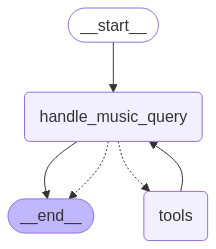

In [16]:
display(Image(music_recommendation_graph.get_graph().draw_mermaid_png()))

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [17]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    - confirmed: Has the user confirmed that they want to proceed?
    """
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"


@tool
def purchase_track(customer_id: int, track_id: int) -> str:
    """
    Purchase a single copy of a track for a customer.
    
    Args:
        customer_id: The ID of the customer making the purchase
        track_id: The ID of the track being purchased
        
    Returns:
        Confirmation of purchase with details or an error message
    """
    # Validate customer exists
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"
    
    # Validate track exists and get both info and price in a single query
    track_query = f"""
        SELECT 
            t.Name as TrackName, 
            ar.Name as ArtistName,
            t.UnitPrice
        FROM tracks t
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE t.TrackId = {track_id}
    """
    
    track_result = db.run(track_query, include_columns=True)
    
    # Parse the result if it's a string
    import ast
    if isinstance(track_result, str):
        try:
            track_result = ast.literal_eval(track_result)
        except:
            return f"Error parsing track information: {track_result}"
    
    if not track_result:
        return f"Error: No track found with ID {track_id}"
    
    # Get price from the tracks table
    unit_price = float(track_result[0]['UnitPrice'])
    track_name = track_result[0]['TrackName']
    artist_name = track_result[0]['ArtistName']
    
    # Current date for the invoice
    from datetime import datetime
    current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    try:
        # Get the next available invoice ID
        invoice_id_result = db.run("SELECT MAX(InvoiceId) + 1 as NextId FROM invoices")
        invoice_id = int(invoice_id_result.strip('[]() \t\n,').split(",")[0])
        
        # Create invoice record
        invoice_query = f"""
        INSERT INTO invoices (InvoiceId, CustomerId, InvoiceDate, Total)
        VALUES ({invoice_id}, {customer_id}, '{current_date}', {unit_price});
        """
        db.run(invoice_query)
        
        # Get the next available invoice line item ID
        line_id_result = db.run("SELECT MAX(InvoiceLineId) + 1 as NextId FROM invoice_items")
        line_id = int(line_id_result.strip('[]() \t\n,').split(",")[0])
        
        # Create invoice item record - quantity is always 1
        item_query = f"""
        INSERT INTO invoice_items (InvoiceLineId, InvoiceId, TrackId, UnitPrice, Quantity)
        VALUES ({line_id}, {invoice_id}, {track_id}, {unit_price}, 1);
        """
        db.run(item_query)
        
        return f"Successfully purchased '{track_name}' by {artist_name} for ${unit_price:.2f}. Invoice #{invoice_id} has been created."
    
    except Exception as e:
        return f"Error completing purchase: {str(e)}"

#### Tools for customer transactions

In [18]:
@tool
def get_customer_invoices(customer_id: int, limit: int = 10):
    """Retrieve the most recent invoices for a customer."""
    return db.run(f"""
        SELECT InvoiceId, InvoiceDate, Total 
        FROM invoices 
        WHERE CustomerId = {customer_id}
        ORDER BY InvoiceDate DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)

@tool
def get_recent_purchases(customer_id: int, limit: int = 5):
    """Get the most recent purchases for quick reference."""
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist,
               ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        ORDER BY i.InvoiceDate DESC
        LIMIT {limit};
    """
    return db.run(query, include_columns=True)


@tool
def check_purchase_history(customer_id: int, date_from: str = None, date_to: str = None, 
                          track_name: str = None, artist_name: str = None, album_title: str = None):
    """
    Check purchase history with flexible filtering options.
    Provide at least one filter parameter (date range, track, artist, or album).
    """
    # Build WHERE clause based on provided parameters
    filters = [f"i.CustomerId = {customer_id}"]
    
    if date_from:
        filters.append(f"i.InvoiceDate >= '{date_from}'")
    if date_to:
        filters.append(f"i.InvoiceDate <= '{date_to}'")
        
    # Use retrievers for fuzzy matching where appropriate
    track_filter = ""
    if track_name:
        docs = song_retriever.invoke(track_name)
        if docs:
            track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
            filters.append(f"t.TrackId IN ({track_ids})")
    
    artist_filter = ""
    if artist_name:
        docs = artist_retriever.invoke(artist_name)
        if docs:
            artist_ids = ", ".join([str(doc.metadata['ArtistId']) for doc in docs[:5]])
            filters.append(f"ar.ArtistId IN ({artist_ids})")
    
    if album_title:
        filters.append(f"al.Title LIKE '%{album_title}%'")
    
    where_clause = " AND ".join(filters)
    
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE {where_clause}
        ORDER BY i.InvoiceDate DESC
        LIMIT 20;
    """
    
    return db.run(query, include_columns=True)

In [19]:
account_query_tools = [
    query_customer_info, 
    get_customer_invoices, 
    get_invoice_details, 
    get_spending_history, 
    get_recent_purchases, 
    check_purchase_history,
    get_track_price_by_id
]
account_update_tools = [update_customer_info, purchase_track]

In [20]:
# account_agent_model_with_tools = account_agent_model.bind_tools(tools=account_query_tools + account_update_tools)
tools_dict = {tool.name: tool for tool in account_query_tools + account_update_tools}

### Node: Router

In [21]:
account_agent_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Determine if the customer request requires:
1. QUERY operations (retrieving information only)
2. UPDATE operations (making changes to customer data or purchases)

Customer ID: {customer_id}
Request context: {input}

Respond with just one word: QUERY or UPDATE
""")

def router_llm(state: MusicStoreChatbotState):
    """Determine if the request is a query or update, without executing it."""
    customer_id = state["customer_id"]

    # Build messages for the account agent
    # human_messages = filter_messages(state["messages"], include_types="human")
    messages = [SystemMessage(content=account_agent_prompt.format(
        customer_id=state["customer_id"], 
        input= state["subsequent_account_query"] if state.get("subsequent_account_query", None) else state["messages"] # human_messages[-1]  # Consider increasing context later
    ))]
    
    response = account_agent_model.invoke(messages)
    
    if "QUERY" in response.content:
        return {"next_node": NodeType.QUERY}
    else:
        assert "UPDATE" in response.content
        return {"next_node": NodeType.UPDATE}

### Node: Query ToolNode

In [22]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def query_node(state):
    """Execute query with full agent executor loop."""
    customer_id = state["customer_id"]
    human_message = get_last_human_message(state["messages"])
    
    # Create a prompt template that includes the required agent_scratchpad
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a helpful music store assistant.
        You are assisting customer with ID: {customer_id}.
        Always use this ID when calling tools that require customer_id.
        Provide helpful, natural language responses based on tool results.
        """),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    
    # Create an OpenAI tools agent
    agent = create_openai_tools_agent(
        llm=account_agent_model,
        tools=account_query_tools,
        prompt=prompt
    )
    
    # Create an executor that will handle the full loop
    agent_executor = AgentExecutor(
        agent=agent,
        tools=account_query_tools,
        verbose=False,  # Set to False in production
        handle_parsing_errors=True
    )

    ####### !!!!!!!!! Accommodating agent to agent interractions
    messages = filter_messages(state["messages"], include_types=["human", "ai"])
    formatted_messages = "\n\n".join([m.content for m in messages])
    # Execute the agent with the customer's query
    result = agent_executor.invoke({
        "input": formatted_messages # human_message.content
    })
    
    # The result includes a final response with tool output incorporated
    final_response = AIMessage(content=result["output"])

    return {
        "messages": state["messages"] + [final_response],
        "next_node": END
    }

### Node: Update Proposal

In [23]:
update_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Create a proposal for the customer's update request.
DO NOT EXECUTE the update yet - just describe what will be done.

Available update tools:
- update_customer_info: Update customer profile information
- purchase_track: Purchase a single copy of a track for a customer

Customer ID: {customer_id}
Customer request: {input}

Format your response as follows:

PROPOSAL:
[Detailed description of the proposed changes]

TOOL: [name of the tool you would use]
PARAMETERS: 
customer_id: {customer_id}
[other parameters needed by the tool with their values inferred from the available context]


IMPORTANT:
Each parameter name is a string with no spaces and starts with an alphabet. For example, `track_id` is a valid parameter name whereas `- track_id` is not.
Once the update tool is chosen, the values for its parameters can be obtained using some of the other tools. Ex.
1. The tool `search_songs` tool can be used to query a track by its name to obtain its `TrackId`, which is a parameter in `purchase_track` 
2. Alternatively, the `get_track_price_by_id` tool can be used to get the `UnitPrice` for a track given its `TrackId` to inform the user of the price before purchasing.
""")

def update_node(state):
    """Creates a proposal for updates without executing them."""
    customer_id = state["customer_id"]
    # latest_message = state["messages"][-1].content
    # context_messages = filter_messages(state["messages"], include_types=["human"])
    context_messages = state["messages"]
    formatted_messages = f"Conversation history: \n\n{[m.content + "\n\n" for m in context_messages]}"

    prompt = update_prompt.format(
        customer_id=customer_id, 
        input=formatted_messages  # latest_message
    )
    
    response = account_agent_model.bind_tools(tools=account_update_tools + account_query_tools + music_search_tools).invoke(prompt)
    content = response.content
    
    # Parse the proposal and tool information
    proposal_text = ""
    tool_name = ""
    parameters = {}
    
    if "PROPOSAL:" in content and "TOOL:" in content:
        proposal_text = content.split("PROPOSAL:")[1].split("TOOL:")[0].strip()
        tool_part = content.split("TOOL:")[1].strip()
        
        if "PARAMETERS:" in tool_part:
            tool_name = tool_part.split("PARAMETERS:")[0].strip()
            params_text = tool_part.split("PARAMETERS:")[1].strip()
            
            # Simple parameter parsing
            for line in params_text.strip().split("\n"):
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if value.startswith('"'):
                        value = value[1:]
                    if value.endswith('"'):
                        value = value[:-1]
                    
                    # Try to convert to appropriate types
                    if value.isdigit():
                        parameters[key] = int(value)
                    else:
                        parameters[key] = value
    
    # Ensure customer_id is always included
    parameters["customer_id"] = customer_id
    
    return {
        "next_node": NodeType.HUMAN_APPROVAL,
        "messages": state["messages"] + [SystemMessage(content=f"Proposed update:\n\nDescription: {proposal_text}\n\nTool: {tool_name}\n\nParameters: {parameters}")]
    }

### Node: Human Approval

In [24]:
def parse_proposal_string(proposal_string):
    # Extract the function name using regex
    tool_match = re.search(r'Tool: ([^\n]+)', proposal_string)
    if not tool_match:
        raise ValueError("Function name not found in the proposal string")
    
    full_function_name = tool_match.group(1).strip()
    
    # Extract module and function names
    parts = full_function_name.split('.')
    module_name = '.'.join(parts[:-1])
    function_name = parts[-1]
    
    # Extract parameters using regex
    params_match = re.search(r'Parameters: ({[^}]+})', proposal_string)
    if not params_match:
        raise ValueError("Parameters not found in the proposal string")
    
    # Convert the string representation of a dict to an actual dict
    params_str = params_match.group(1)
    parameters = ast.literal_eval(params_str)
    
    return module_name, function_name, parameters

def human_approval_node(state):
    """Handles human-in-the-loop approval for updates."""
    message = state["messages"][-1].content
    approved = state.get("approved", None)

    if approved is None:
        raise NodeInterrupt(f"{action_confirmation_interrupt_message}\n\n{state["messages"][-1].content}")
    
    # The approval decision now comes from the interruption
    if approved:
        module_name, function_name, parameters = parse_proposal_string(message)
        assert function_name in tools_dict, f"Tool not found: {function_name}"
        tool = tools_dict[function_name]
        result = tools_dict[function_name].invoke(parameters)
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content=f"Tool: {function_name}, Result: {result}")],
            "approved": None
        }
    else:
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content="Update not approved by user")]
        }

### Node: Response LLM

In [25]:
response_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store working as the final step of the helpdesk. 
Provide a natural language response to the customer.

Customer request: {input}

{context}

Respond in a helpful, friendly way but there is no need to greet the user.
Summarize what was done or found. 
If there was an error, explain what went wrong in simple terms.
""")

def response_llm(state):
    """Generates natural language responses based on tool results."""
    latest_message = state["messages"][-1].content
    
    response = account_agent_model.invoke(response_prompt.format(
        input=get_last_human_message(state["messages"]),
        context=state["messages"][-1].content
    ))
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}


### Graph definition

In [26]:
account_agent_graph_builder = StateGraph(MusicStoreChatbotState)

# Add nodes
account_agent_graph_builder.add_node(NodeType.ROUTER, router_llm)
account_agent_graph_builder.add_node(NodeType.QUERY, query_node)
account_agent_graph_builder.add_node(NodeType.UPDATE, update_node)
account_agent_graph_builder.add_node(NodeType.HUMAN_APPROVAL, human_approval_node)
account_agent_graph_builder.add_node(NodeType.RESPONSE, response_llm)

# Add edges
account_agent_graph_builder.add_conditional_edges(
    NodeType.ROUTER,
    lambda x: x.get("next_node"),
    {
        NodeType.QUERY: NodeType.QUERY,
        NodeType.UPDATE: NodeType.UPDATE
    }
)
account_agent_graph_builder.add_edge(NodeType.QUERY, END)
account_agent_graph_builder.add_edge(NodeType.UPDATE, NodeType.HUMAN_APPROVAL)
account_agent_graph_builder.add_edge(NodeType.HUMAN_APPROVAL, NodeType.RESPONSE)
account_agent_graph_builder.add_edge(NodeType.RESPONSE, END)

# Set the entry point
account_agent_graph_builder.set_entry_point(NodeType.ROUTER)

account_agent_memory = MemorySaver()
# Compile the graph
account_agent_graph = account_agent_graph_builder.compile(
    checkpointer=account_agent_memory
)


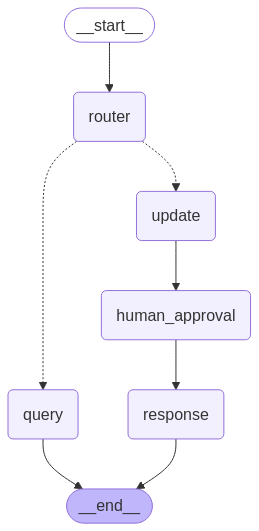

In [27]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

# Compound Agent

## Set up graph

### Node: Request Routing

In [28]:
derive_id_message = """Your task is to determine the customer ID from text that represents a sequence of 
queries from the user.
For example, 
1. if a query says 'My customer ID is 123' then you should return 123.
2. if the query says 'I want to switch from talking about customer 123 to customer 456', then return 456.
If the customer ID is not part of the query, return UNKNOWN.
For example, if the query is 'Recommend music from U2', return UNKNOWN.

When the sequence represents a conversation, like:
```My customer ID is 123. Recommend music by U2.

What is the most popular song by Green Day?
```
you should be able to determine that the customer ID is 123

Return ONLY the customer ID number, ex. '123' or the string 'UNKNOWN'
"""

router_system_message = ChatPromptTemplate.from_template("""You are a helpful customer support assistant for a music store.
Your job is to determine which group the customer request falls into:

1. ACCOUNT - For updating personal information, and making purchases for a particular track/song
2. MUSIC - For music recommendations (such as popular songs), searching for songs/artists, or questions about music inventory
3. UNRELATED - for anything that does not fit into ACCOUNT or MUSIC
4. SEQUENTIAL - For first getting a music recommendation, like identifying a particular track, then performing a account action, like purchasing the track

Sometimes the user might provide their customer ID up front. 
This does not necessarily indicate an account query. 
For example, "My customer ID is 4. Please recommend music by Linkin Park" is still a music query
Example of account query- "Help me update my email to john@doe.com" or "show me my contact details"
Example of sequential query- "Purchase the most popular Taylor Swift track"
Example of unrelated query- "Who is the President of Mexico?"

Respond with only the name of the group (ACCOUNT, MUSIC, UNRELATED or SEQUENTIAL) that best matches their query.

Customer request: {customer_request}
""")

decompose_prompt = ChatPromptTemplate.from_template("""
Decompose this query into two separate parts:
1. A music query for music recommendations (such as popular songs), searching for songs/artists, or questions about music inventory
2. An account query to process after getting results from the music query. Account queries are for updating personal information, and making purchases for a particular track/song

Original query: {last_human_message}

Make sure that the entire semantic meaning of the original query is captured by the decomposed queries. Fpr the music query, when applicable, ask for identifying information.
For example, "Purchase the most popular track by U2" could be split 
into a Music query- "Determine the most popular track by U2 and provide its ID" and 
an account query "Purchase the identified track ID"

Format your response exactly as follows:
MUSIC_QUERY: [Query for music identification]
ACCOUNT_QUERY: [Query for account action, referencing results from music query]
""")

def get_customer_id_from_history(state: MusicStoreChatbotState) -> str:
    human_messages = filter_messages(state["messages"], include_types="human")
    formatted_human_messages = "\n\n".join([m.content for m in human_messages])
    derived_id_response = helpdesk_agent_model.invoke([SystemMessage(content=derive_id_message)] + human_messages)
    return derived_id_response.content


def route_conversation(state: MusicStoreChatbotState) -> dict:
    """Route the conversation to the appropriate department"""
    state_update = {}  # stores the partial update returned by this function

    # check if the user ID is available in the latest human query
    derived_id = get_customer_id_from_history(state)
    if derived_id.isdigit() and query_customer_info.invoke({"customer_id": int(derived_id)}) != "":
        state_update["customer_id"] = int(derived_id)
    elif state["customer_id"] is None:
        raise NodeInterrupt(customer_id_interrupt_message)

    human_messages = filter_messages(state["messages"], include_types="human")
    router_messages = [SystemMessage(content=router_system_message.format(customer_request=human_messages[-1].content))]
    response = helpdesk_agent_model.invoke(router_messages)

    # Update the state with the correct department
    content = response.content.lower()
    if "account" in content:
        state_update["current_mode"] = "account"
    elif "music" in content:
        state_update["current_mode"] = "music"
    elif "unrelated" in content:
        state_update["current_mode"] = "unrelated"
    else:
        assert "sequential" in content, f"Unidentified response, {content}"
        decompose_response = helpdesk_agent_model.invoke(
            [
                SystemMessage(
                    content=decompose_prompt.format(last_human_message=human_messages[-1])
                )
            ]
        )
        decomposed_content = decompose_response.content
        assert "MUSIC_QUERY:" in decomposed_content and "ACCOUNT_QUERY:" in decomposed_content, f"Unexpected content: {decomposed_content}"
        music_query = decomposed_content.split("MUSIC_QUERY:")[1].split("ACCOUNT_QUERY:")[0].strip()
        account_query = decomposed_content.split("ACCOUNT_QUERY:")[1].strip()

        state_update["messages"] = state["messages"] + [SystemMessage(f"Music query: {music_query}")]
        state_update["subsequent_account_query"] = account_query
        # First start with the music agent
        state_update["current_mode"] = "music"
        # raise ValueError(f"Sequential requests not supported yet\n\nQuery split as:\n\nMUSIC{music_query}\n\nACCOUNT:{account_query}")

    # state_update["messages"] = state["messages"] + [SystemMessage(f"Request classified as `{state_update['current_mode']}`")]

    return state_update


def route_condition(state: MusicStoreChatbotState) -> str:
    """Return the routing condition based on the current state"""
    return state["current_mode"]

### Node: Out of Scope Queries

In [29]:
def out_of_scope_message_node(state: MusicStoreChatbotState):
    """Node that mocks an agent that can respond only with a default message for unrelated queries."""
    response = "I can only help with music recommendations and account updates. Please try again"
    return {
        "messages": state["messages"] + [AIMessage(response)]
    }

In [30]:
def music_to_account_condition(state: MusicStoreChatbotState) -> str:
    """Determine if the flow should continue to account node after music node"""
    if state.get("subsequent_account_query", False):
        return "account"
    else:
        return "end"

### Graph definition

In [31]:
front_desk_graph_builder = StateGraph(MusicStoreChatbotState)
front_desk_graph_builder.add_node("route_conversation", route_conversation)
front_desk_graph_builder.add_node("music_node", music_recommendation_graph_builder.compile())
# front_desk_graph_builder.add_node("account_node", account_node)
front_desk_graph_builder.add_node("account_node", account_agent_graph_builder.compile())
front_desk_graph_builder.add_node("out_of_scope_message_node", out_of_scope_message_node)

# Add the starting edge
front_desk_graph_builder.add_edge(START, "route_conversation")

# The routing node connects to the three other nodes
front_desk_graph_builder.add_conditional_edges(
    "route_conversation",  # Source node
    route_condition,  # Function that returns the condition value
    {
        "music": "music_node",
        "account": "account_node",
        "unrelated": "out_of_scope_message_node"
    }
)

# The music node routes to the account node if there is a pending account action, else goes to end
front_desk_graph_builder.add_conditional_edges(
    "music_node",
    music_to_account_condition,
    {
        "account": "account_node",
        "end": END
    }
)

# Add the ending edges
front_desk_graph_builder.add_edge("account_node", END)
front_desk_graph_builder.add_edge("out_of_scope_message_node", END)

memory = MemorySaver()
front_desk_graph = front_desk_graph_builder.compile(checkpointer=memory)

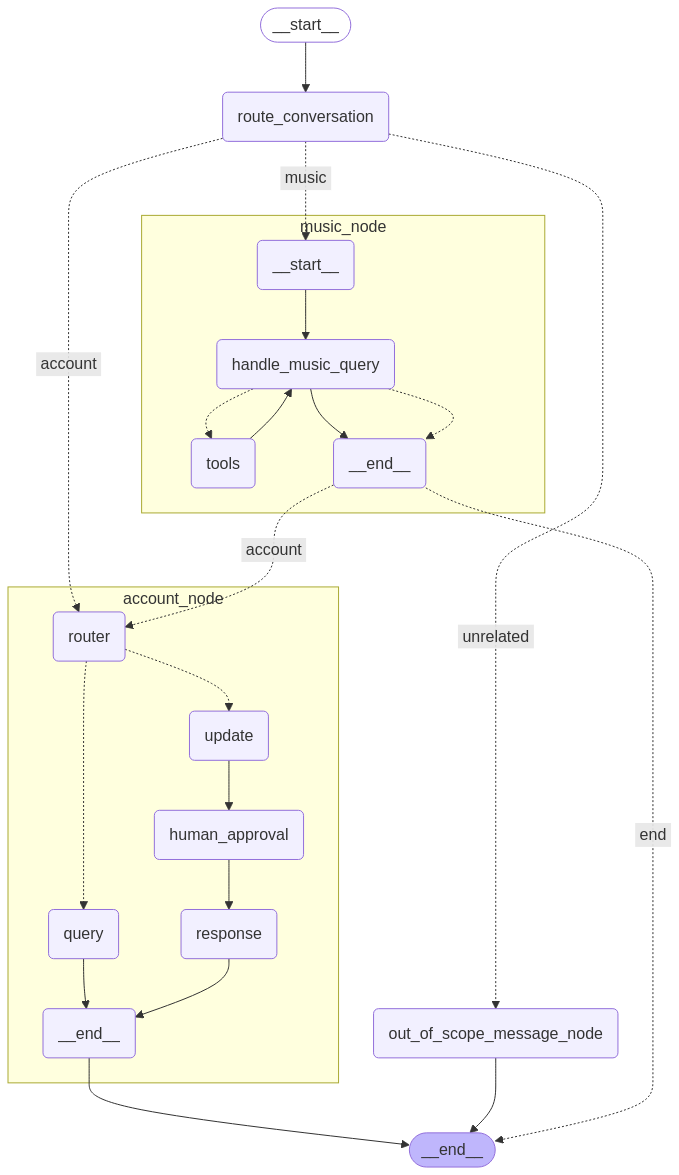

In [32]:
display(Image(front_desk_graph.get_graph(xray=True).draw_mermaid_png()))

# New Execution Logic

In [33]:
def run_agent_with_interruption_handling(message, thread_id=uuid.uuid4(), graph=front_desk_graph):
    """
    Run an agent graph with elegant handling of multiple possible interruptions.
    
    Args:
        graph: The compiled LangGraph to run
        initial_input: The initial state to provide to the graph
        thread_config: Thread configuration dictionary
    
    Returns:
        The final response from the graph
    """
    current_input = {
        "messages": [HumanMessage(content=message)], 
        "current_mode": "router", 
        "next_node": NodeType.ROUTER, 
        "customer_id": None
    }
    thread_config = {"configurable": {"thread_id": thread_id}}
    all_messages = current_input["messages"]
    
    while True:
        
        for event in graph.stream(current_input, thread_config, stream_mode="values"):

            # Add new messages to our collection and display them
            if 'messages' in event and event['messages']:
                new_messages = [msg for msg in event['messages'] if msg not in all_messages]
                all_messages = event['messages']
                
                for msg in [m for m in new_messages if m.type not in ["system", "tool"]]:
                    if hasattr(msg, "additional_kwargs") and "tool_calls" in msg.additional_kwargs and msg.additional_kwargs["tool_calls"]:
                        continue
                    msg.pretty_print()

        # Get the state to check for completion or interruption
        state = graph.get_state(thread_config)
        
        # Check if the graph completed execution
        if state.next == ():
            print("\n========================= ✅ Done =========================")
            return all_messages

        # If we're here, there might be an interruption
        if state.tasks and any(task.interrupts for task in state.tasks):
            # Find the first task with interrupts
            interrupt_task = next(task for task in state.tasks if task.interrupts)
            interrupt_message = interrupt_task.interrupts[0].value
            node_name = interrupt_task.name
            
            # Handle the interruption based on its type
            interrupt_handler = identify_interrupt_handler(interrupt_message, node_name)
            
            if interrupt_handler:
                # Use the handler to update the state and get new input (if any)
                current_input = interrupt_handler(graph, state, thread_config, interrupt_message)
            else:
                print(f"❌ Unknown interruption type: {interrupt_message}")
                print(state)
                return all_messages
        else:
            # If no tasks with interrupts but graph didn't reach END,
            # something else might be wrong
            print(f"❌ Graph execution stopped unexpectedly")
            return all_messages

def identify_interrupt_handler(interrupt_message, node_name=None):
    """
    Identify the appropriate handler function based on the interruption message.
    
    Args:
        interrupt_message: The message from the interruption
    
    Returns:
        The handler function or None if no matching handler is found
    """
    if customer_id_interrupt_message in interrupt_message:
        return handle_customer_id_interrupt
    elif action_confirmation_interrupt_message in interrupt_message:
        return handle_confirmation_interrupt
    else:
        print(f"❌ Unindentified interrupt message {interrupt_message}")
        return handle_generic_interrupt

def handle_customer_id_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting customer ID."""
    customer_id_input = input(f"\n🔍 {interrupt_message}")
    
    # Validate input
    if customer_id_input.isdigit():
        
        graph.update_state(
            thread_config,
            {
                "customer_id": int(customer_id_input),  # "customer_id": state.values.get("customer_id"),
                "current_mode": state.values.get("current_mode", "router"),
                "messages": state.values["messages"], # new_messages
                "next_node": state.values.get("next_node", NodeType.ROUTER),
            }
        )
        
        # No new input needed, just continue with the updated state
        return None
    else:
        return handle_customer_id_interrupt(graph, state, thread_config, interrupt_message)

def handle_confirmation_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting confirmation for action."""
    confirmation = input(f"\n{interrupt_message} (yes/no): \n").lower()
    
    if confirmation in ("yes", "y"):
        
        graph.update_state(
            thread_config,
            {
                "messages": state.values["messages"], # new_messages
                "current_mode": state.values.get("current_mode", "router"),
                "customer_id": state.values.get("customer_id", None),
                "next_node": state.values.get("next_node", NodeType.ROUTER),
                "approved": True
            }
        )
    else:
        # Add rejection message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="No, I don't want to proceed with this.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": state.values["messages"], # new_messages
                "current_mode": state.values.get("current_mode", "router"),
                "customer_id": state.values.get("customer_id", None),
                "next_node": state.values.get("next_node", NodeType.ROUTER),
                "approved": False
            }
        )


def handle_generic_interrupt(graph, state, thread_config, interrupt_message):
    """Handle any other type of interruption generically."""
    user_response = input(f"\n{interrupt_message} \nYour response: ")
    
    new_messages = state.values["messages"] + [
        HumanMessage(content=user_response)
    ]
    
    graph.update_state(
        thread_config,
        {
            "messages": new_messages,
            "current_mode": state.values.get("current_mode", "router"),
            "customer_id": state.values.get("customer_id", None),
            "next_node": state.values.get("next_node", NodeType.ROUTER),
        }
    )

# Tests

## Music agent only

In [34]:
messages = run_agent_with_interruption_handling("My Customer ID is 2. I like U2. What other music should I listen to?", thread_id="1-1")

================================== Ai Message ==================================

Great choice with U2! Based on your purchase history and preferences, here are some recommendations and insights:

### Top Genres:
1. **Rock** - Your most purchased genre, which aligns perfectly with U2's style.
2. **Blues** - A genre you seem to enjoy, with artists like Eric Clapton in your collection.
3. **Latin** - A bit of a surprise, but it adds a nice variety to your taste.
4. **Soundtrack** - You have a few purchases here, which might indicate a love for cinematic music.
5. **Alternative & Punk** - Another genre that complements your rock preferences.

### Top Artists:
1. **Eric Clapton** - You have a strong affinity for his bluesy rock style.
2. **Pearl Jam** - Another rock band that shares some similarities with U2.
3. **Buddy Guy** - A blues legend, adding depth to your blues collection.
4. **U2** - Of course, a favorite of yours!
5. **Paul D'Ianno** - Known for his work with Iron Maiden, adding

In [35]:
messages = run_agent_with_interruption_handling("Based on my past purchases, can you describe my taste in music?", thread_id="2-1")


🔍 Please provide your customer ID to help me assist you better. 2


================================== Ai Message ==================================

Based on your recent purchases, it seems you have a strong appreciation for classic rock and blues music. Here's a breakdown of your taste:

1. **Classic Rock**: You enjoy tracks from iconic rock bands and artists like The Who, as seen with your purchase of "Boris The Spider."

2. **Blues**: You have a significant interest in blues music, particularly with multiple purchases of tracks by Eric Clapton, such as "Bell Bottom Blues," "Swing Low Sweet Chariot," and "Before You Accuse Me." You also enjoy Buddy Guy's blues tracks like "First Time I Met The Blues" and "Stone Crazy."

3. **Heavy Metal**: You have a taste for heavy metal as well, with a purchase from Bruce Dickinson, known for his work with Iron Maiden, with the track "The Alchemist."

Your music collection reflects a blend of classic rock, blues, and a touch of heavy metal, showcasing a diverse and rich taste in music.

========================= ✅

In [36]:
messages = run_agent_with_interruption_handling("Is Boulevard of Broken Dreams available at the store?", thread_id="3-1")


🔍 Please provide your customer ID to help me assist you better. 2


================================== Ai Message ==================================

Yes, "Boulevard of Broken Dreams" is available at our store. If you're interested in purchasing it or need more information, feel free to ask!

========================= ✅ Done =========================


## Account agent only

### Query requests

In [37]:
messages = run_agent_with_interruption_handling("Please show me my contact information that you have on file", thread_id="4-1")


🔍 Please provide your customer ID to help me assist you better. 2


================================== Ai Message ==================================

Here is the contact information we have on file for you:

- **Name:** Leonie Köhler
- **Address:** Theodor-Heuss-Straße 34, 70174 Stuttgart, Germany
- **Phone:** +49 0711 2842222
- **Email:** leonekohler@surfeu.de

If you need to update any of this information, please let me know!

========================= ✅ Done =========================


In [38]:
messages = run_agent_with_interruption_handling("My customer ID is 2. How much money have I spent in total?", thread_id="5-1")

================================== Ai Message ==================================

You've spent a total of $37.62 on your purchases. If you have any other questions or need further assistance, feel free to ask!

========================= ✅ Done =========================


In [39]:
messages = run_agent_with_interruption_handling("Show me my recent purchases. How much money have I spent in total?", thread_id="6-1")


🔍 Please provide your customer ID to help me assist you better. 2


================================== Ai Message ==================================

Here are your recent purchases:

1. **Boris The Spider** by The Who - $0.99 (Purchased on 2012-07-13)
2. **Bell Bottom Blues** by Eric Clapton - $0.99 (Purchased on 2011-11-23)
3. **Swing Low Sweet Chariot** by Eric Clapton - $0.99 (Purchased on 2011-11-23)
4. **Let It Grow** by Eric Clapton - $0.99 (Purchased on 2011-11-23)
5. **Before You Accuse Me** by Eric Clapton - $0.99 (Purchased on 2011-11-23)

In total, you have spent $37.62 on your purchases. If you have any more questions or need further assistance, feel free to ask!

========================= ✅ Done =========================


### Update requests

In [40]:
print(f"Before: {query_customer_info.invoke({"customer_id": 2})}")

print("="*100)
message = "My Customer ID is 2. I want to update my email to test@this-1.com"
print(f"Graph invoked with {message}")
messages = run_agent_with_interruption_handling(message, thread_id="7-1")

print(f"\n\nAfter: {query_customer_info.invoke({"customer_id": 2})}\n\n")

print("="*100)
rollback_message = "Now set my email back to leonekohler@surfeu.de"
print(f"Graph invoked with {rollback_message}")
messages = run_agent_with_interruption_handling(rollback_message, thread_id="7-1")

print(f"\n\nAfter rollback request: {query_customer_info.invoke({"customer_id": 2})}")

Before: [(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5)]
Graph invoked with My Customer ID is 2. I want to update my email to test@this-1.com



This action will update the database. Please confirm that you want to proceed (yes/no)

Proposed update:

Description: The customer has requested to update their email address to "test@this-1.com". This change will be made to the customer's profile, ensuring that all future communications and notifications are sent to the new email address. This update will be performed using the `update_customer_info` tool, specifically targeting the "Email" field for Customer ID 2.

Tool: update_customer_info

Parameters: {'customer_id': 2, 'field': 'Email', 'value': 'test@this-1.com'} (yes/no): 
 yes


================================== Ai Message ==================================

Your email address has been successfully updated to 'test@this-1.com' for your customer ID 2. If there's anything else you need help with, feel free to let me know!

========================= ✅ Done =========================


After: [(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'test@this-1.com', 5)]


Graph invoked with Now set my email back to leonekohler@surfeu.de
================================ Human Message =================================

My Customer ID is 2. I want to update my email to test@this-1.com
================================== Ai Message ==================================

Your email address has been successfully updated to 'test@this-1.com' for your customer ID 2. If there's anything else you need help with, feel free to let me know!



This action will update the database. Please confirm that you want to proceed (yes/no)

Proposed update:

Description: The customer has requested to revert their email address back to "leonekohler@surfeu.de". This change will be made to the customer's profile, ensuring that all future communications and notifications are sent to the reverted email address. The update will be performed using the `update_customer_info` tool, specifically targeting the "Email" field for Customer ID 2.

Tool: update_customer_info

Parameters: {'customer_id': 2, 'field': 'Email', 'value': 'leonekohler@surfeu.de'} (yes/no): 
 yes


================================== Ai Message ==================================

Your email has been successfully updated to leonekohler@surfeu.de. If there's anything else you need help with, feel free to let me know!

========================= ✅ Done =========================


After rollback request: [(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5)]


In [41]:
messages = run_agent_with_interruption_handling("My Customer ID is 2. I want to purchase Boulevard of Broken Dreams", thread_id="8-1")

================================== Ai Message ==================================

You can purchase "Boulevard of Broken Dreams" by Green Day for $0.99. Would you like to proceed with the purchase?



This action will update the database. Please confirm that you want to proceed (yes/no)

Proposed update:

Description: The customer with ID 2 has requested to purchase the track "Boulevard of Broken Dreams" by Green Day. The track has been identified with Track ID 1136 and is priced at $0.99. The proposal is to proceed with the purchase of this track for the customer.

Tool: purchase_track

Parameters: {'customer_id': 2, 'track_id': 1136} (yes/no): 
 yes


================================== Ai Message ==================================

Your purchase of "Boulevard of Broken Dreams" by Green Day has been successfully completed for $0.99. An invoice has been created for this transaction, and it's numbered #413. If you have any more questions or need further assistance, feel free to ask!

========================= ✅ Done =========================


## Complex query- Music agent and Account agent

In [ ]:
messages = run_agent_with_interruption_handling("Purchase the most popular track by U2.", thread_id="9-1")


🔍 Please provide your customer ID to help me assist you better. 2


================================== Ai Message ==================================

The most popular track by U2, "With Or Without You," is available for purchase at $0.99. Would you like to proceed with the purchase?



This action will update the database. Please confirm that you want to proceed (yes/no)

Proposed update:

Description: The customer has requested to purchase the most popular track by U2, which has been identified as "With Or Without You." The track is available for purchase at a price of $0.99. The proposed action is to proceed with purchasing this track for the customer with ID 2.

Tool: purchase_track

Parameters: {'- customer_id': 2, '- track_id': 3006, 'customer_id': 2} (yes/no): 
 no


## Irrelevant queries

In [ ]:
messages = run_agent_with_interruption_handling("My customer ID is 2. What is the meaning of life?", thread_id="10-1")

# Playground

In [ ]:
# s = MusicStoreChatbotState(
#     messages = [],
#     customer_id = 1,
#     next_node = NodeType.ROUTER,
#     approved = None,
#     current_mode = "router"
# )

In [ ]:
def view_table(table_name, limit=10, offset=0, where_clause=""):
    """
    View a specified number of rows from any table in the database as raw output.
    
    Args:
        table_name: Name of the table to view
        limit: Maximum number of rows to return (default: 10)
        offset: Number of rows to skip (default: 0)
        where_clause: Optional WHERE clause without the 'WHERE' keyword (default: "")
        
    Returns:
        List of dictionaries containing query results
    """
    import ast
    
    # Validate table name
    tables = db.get_usable_table_names()
    if table_name not in tables:
        return f"Table '{table_name}' not found. Available tables: {', '.join(tables)}"
    
    # Build query
    where_part = f" WHERE {where_clause}" if where_clause else ""
    query = f"SELECT * FROM {table_name}{where_part} LIMIT {limit} OFFSET {offset}"
    
    try:
        # Execute query with column names included
        result = db.run(query, include_columns=True)
        
        # Parse the string result into a Python object
        if isinstance(result, str):
            try:
                # Using ast.literal_eval to safely evaluate the string as a Python literal
                parsed_result = ast.literal_eval(result)
                columns = parsed_result[0].keys()
                print(columns)
                for r in parsed_result:
                    print(f"{[r[c] for c in columns]}")
                return parsed_result
            except (ValueError, SyntaxError) as parse_error:
                return f"Error parsing result: {str(parse_error)}\nRaw result: {result}"
        
        return result  # Return as is if already a Python object
        
    except Exception as e:
        return f"Error viewing table: {str(e)}"

In [ ]:
# r = view_table('invoice_items')
r = view_table('invoices', where_clause="CustomerId=2", limit=100)

In [ ]:
sum([i["Total"] for i in r])

In [ ]:
# import sys
# !{sys.executable} -m pip install pandas